# 📘 Notebook 4 — ESG Insights and Reporting

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# Global style and paths
# ---------------------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

# ---------------------------------------------------------------
# Load prior outputs
# ---------------------------------------------------------------
DATA_FILE = DATA_PROCESSED / "esg_processed_02b.csv"
MODEL_SUMMARY_FILE = OUTPUTS / "model_evaluation_summary.json"

df = pd.read_csv(DATA_FILE)

with open(MODEL_SUMMARY_FILE, "r") as f:
    model_summary = json.load(f)

print("✅ Environment setup complete.")
print(f"Data shape: {df.shape}")
print(f"Loaded model summary metrics from: {MODEL_SUMMARY_FILE.name}")

✅ Environment setup complete.
Data shape: (11000, 19)
Loaded model summary metrics from: model_evaluation_summary.json


🔍 Dataset Overview:


,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,ESG_Class,CarbonEmissions_log,ESG_Overall_noisy
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,4.9,57.0,63.183571,40.611818,64.168894,35577.4,17788.7,71154.7,0,10.479494,52.845239
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.208678,42.708056,66.542390,37314.7,18657.4,74629.4,1,10.527169,62.325608
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,60.838443,46.309691,70.762512,45006.4,22503.2,90012.9,0,10.714582,53.484680


Shape: (11000, 19)

Columns:
 ['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption', 'ESG_Class', 'CarbonEmissions_log', 'ESG_Overall_noisy']

📊 ESG Pillar Summary:


,count,mean,std,min,25%,50%,75%,max
ESG_Environmental,11000.0,56.39,27.24,-14.60,34.47,55.65,79.02,116.06
ESG_Social,11000.0,53.52,17.38,2.93,41.71,53.64,65.54,101.58
ESG_Governance,11000.0,51.27,17.95,-3.18,38.87,51.55,63.95,101.64
ESG_Overall_noisy,11000.0,54.63,17.69,0.00,42.45,54.78,67.13,100.00



💰 Financial Variable Summary:


,count,mean,std,min,25%,50%,75%,max
Revenue,11000.0,4670.85,9969.95,35.9,938.78,1902.30,4342.62,1.808104e+05
ProfitMargin,11000.0,10.90,8.76,-20.0,5.30,10.50,16.30,5.000000e+01
MarketCap,11000.0,13380.62,39922.87,1.8,1098.52,3096.45,9995.50,8.652717e+05
GrowthRate,11000.0,4.84,8.99,-36.0,-0.60,4.90,10.30,3.800000e+01
CarbonEmissions,11000.0,1271462.35,5067760.30,2042.2,122852.95,292073.45,740731.12,1.741047e+08
EnergyConsumption,11000.0,11658393.75,50958356.02,5105.5,306916.12,1221745.45,5616436.72,1.741047e+09
WaterUsage,11000.0,560044.15,1565686.22,1021.1,64884.68,203880.45,525187.98,5.223142e+07


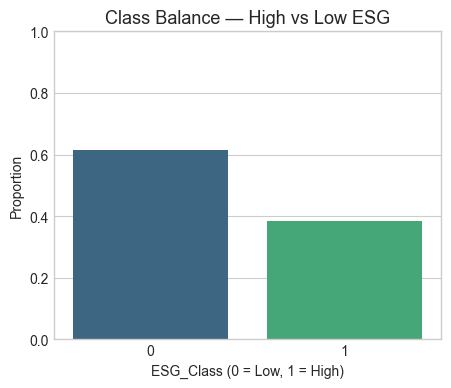

Class balance:
{0: '61.40%', 1: '38.60%'}


In [2]:
# %% ===============================================================
# STEP 1 — DATA OVERVIEW & CONTEXT
# ===============================================================

# --- Basic dataset info ---
print("🔍 Dataset Overview:")
display(df.head(3))
print(f"Shape: {df.shape}")
print("\nColumns:\n", df.columns.tolist())

# --- Basic statistics for ESG pillars and financials ---
esg_cols = ["ESG_Environmental", "ESG_Social", "ESG_Governance", "ESG_Overall_noisy"]
financial_cols = ["Revenue", "ProfitMargin", "MarketCap", "GrowthRate", "CarbonEmissions", "EnergyConsumption", "WaterUsage"]

print("\n📊 ESG Pillar Summary:")
display(df[esg_cols].describe().T.round(2))

print("\n💰 Financial Variable Summary:")
display(df[financial_cols].describe().T.round(2))

# --- ESG class balance ---
class_balance = df["ESG_Class"].value_counts(normalize=True).sort_index()
plt.figure(figsize=(5,4))
sns.barplot(x=class_balance.index, y=class_balance.values, palette="viridis")
plt.title("Class Balance — High vs Low ESG", fontsize=13)
plt.ylabel("Proportion")
plt.xlabel("ESG_Class (0 = Low, 1 = High)")
plt.ylim(0, 1)
plt.show()

print("Class balance:")
print(class_balance.map("{:.2%}".format).to_dict())

📈 Model Evaluation Summary (from Notebook 03):


,Value
Cross-Validation ROC-AUC (mean)_Logistic Regression,0.932042
Cross-Validation ROC-AUC (mean)_Random Forest,0.922665
Cross-Validation ROC-AUC (mean)_XGBoost,0.925595
Test ROC-AUC_Logistic Regression,0.925803
Test ROC-AUC_Random Forest,0.916101
Test ROC-AUC_XGBoost,0.920717
Best Thresholds_Balanced (max F1),0.366791
Best Thresholds_High Recall (≈ 0.90),0.222248
Best Thresholds_High Precision (≈ 0.90),0.714136
Brier Score_Uncalibrated,0.111257


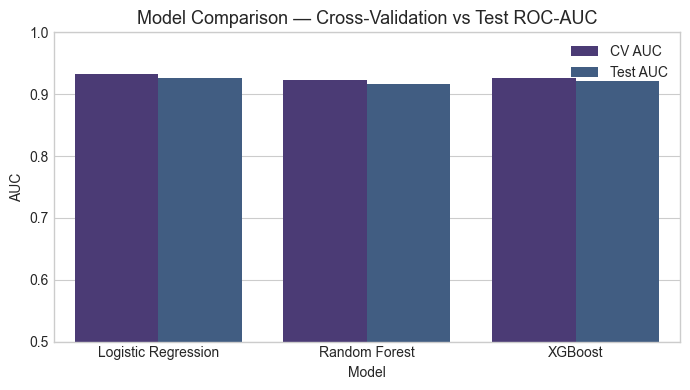

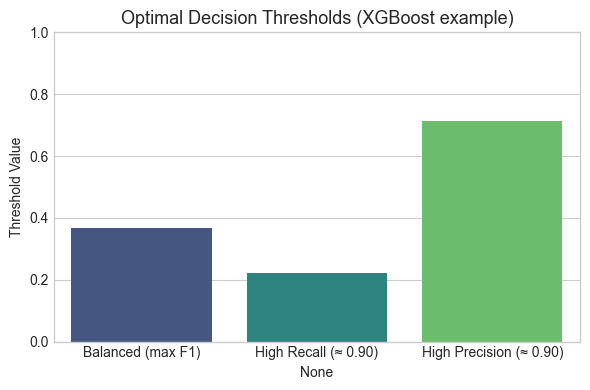

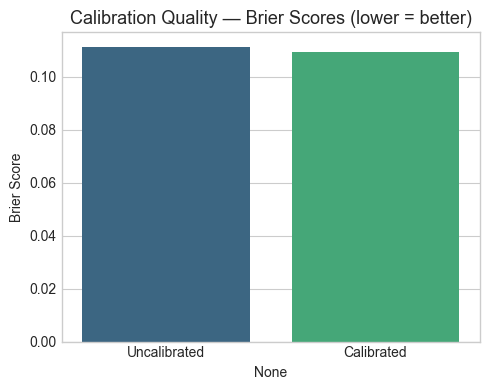


✅ Summary of Key Metrics:
Logistic Regression  | Test ROC-AUC: 0.926
Random Forest        | Test ROC-AUC: 0.916
XGBoost              | Test ROC-AUC: 0.921

Brier Scores: Uncalibrated = 0.111, Calibrated = 0.109
Thresholds: {'Balanced (max F1)': 0.3667907118797302, 'High Recall (≈ 0.90)': 0.22224783897399902, 'High Precision (≈ 0.90)': 0.7141358852386475}


In [3]:
# %% ===============================================================
# STEP 2 — MODEL PERFORMANCE SUMMARY
# ===============================================================

# --- Load metrics from Notebook 03 ---
print("📈 Model Evaluation Summary (from Notebook 03):")

# Convert to DataFrame for better visualization
model_eval = pd.json_normalize(model_summary, sep="_").T
model_eval.columns = ["Value"]
display(model_eval)

# --- Extract sections separately for visualization ---
cv_auc = pd.Series(model_summary["Cross-Validation ROC-AUC (mean)"], name="CV AUC")
test_auc = pd.Series(model_summary["Test ROC-AUC"], name="Test AUC")
brier_scores = pd.Series(model_summary["Brier Score"], name="Brier")

thresholds = pd.Series(model_summary["Best Thresholds"], name="Thresholds")

# --- Combined AUC comparison plot ---
auc_df = pd.DataFrame({
    "Model": cv_auc.index,
    "CV AUC": cv_auc.values,
    "Test AUC": test_auc.values
})

auc_df_melt = auc_df.melt(id_vars="Model", var_name="Metric", value_name="AUC")

plt.figure(figsize=(7,4))
sns.barplot(data=auc_df_melt, x="Model", y="AUC", hue="Metric")
plt.title("Model Comparison — Cross-Validation vs Test ROC-AUC", fontsize=13)
plt.ylim(0.5, 1)
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Threshold visualization ---
plt.figure(figsize=(6,4))
sns.barplot(x=thresholds.index, y=thresholds.values, palette="viridis")
plt.title("Optimal Decision Thresholds (XGBoost example)", fontsize=13)
plt.ylabel("Threshold Value")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- Calibration summary ---
plt.figure(figsize=(5,4))
sns.barplot(x=brier_scores.index, y=brier_scores.values, palette="viridis")
plt.title("Calibration Quality — Brier Scores (lower = better)", fontsize=13)
plt.ylabel("Brier Score")
plt.tight_layout()
plt.show()

# --- Summary printout ---
print("\n✅ Summary of Key Metrics:")
for model, auc in test_auc.items():
    print(f"{model:<20} | Test ROC-AUC: {auc:.3f}")
print(f"\nBrier Scores: Uncalibrated = {brier_scores['Uncalibrated']:.3f}, Calibrated = {brier_scores['Calibrated']:.3f}")
print(f"Thresholds: {thresholds.to_dict()}")

PermutationExplainer explainer: 1001it [00:41, 19.30it/s]                          


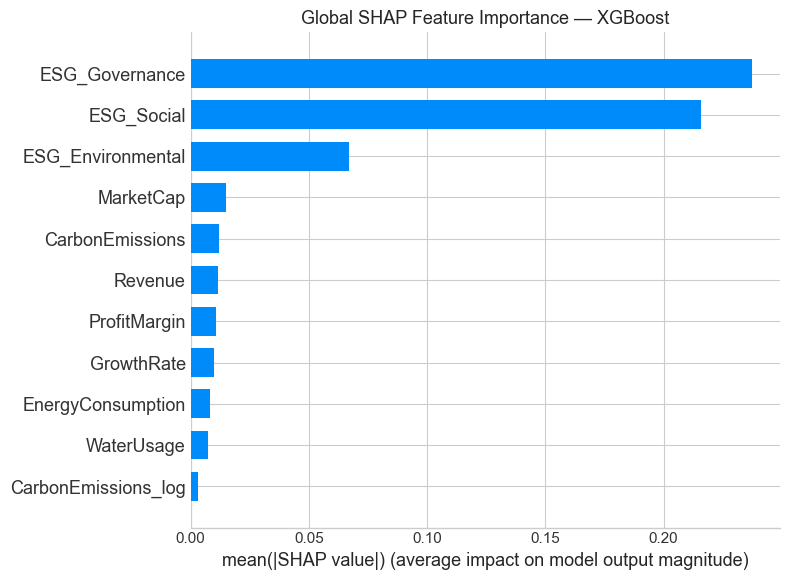

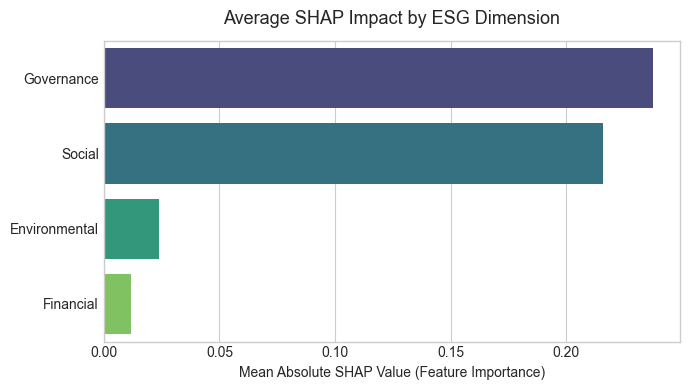

,Mean |SHAP Value|
Governance,2.37e-01
Social,2.16e-01
Environmental,2.36e-02
Financial,1.18e-02


In [4]:
# %% ===============================================================
# STEP 3 — ESG FEATURE IMPORTANCE SYNTHESIS
# ===============================================================
import shap

# --- Reload the trained model (if needed) ---
# Optional: if you wish to reuse the model from Notebook 03
# Otherwise, skip this if Notebook 03 is still in memory
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
X = df.drop(columns=[
    "CompanyID", "CompanyName", "Industry", "Region", "Year",
    "ESG_Overall", "ESG_Overall_noisy", "ESG_Class"
])
y = df["ESG_Class"]
xgb.fit(X, y)

# --- Compute SHAP values (model-agnostic approach, slower but robust) ---
sample_X = X.sample(1000, random_state=42)

# Use PermutationExplainer to bypass TreeExplainer compatibility issues
explainer = shap.Explainer(xgb.predict, sample_X)
shap_values = explainer(sample_X)

# --- 3.1 Feature-level importance ---
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=False)
plt.title("Global SHAP Feature Importance — XGBoost", fontsize=13)
plt.tight_layout()
plt.show()

# --- 3.2 ESG Dimension Aggregation ---
esg_groups = {
    "Environmental": ["ESG_Environmental", "CarbonEmissions", "EnergyConsumption", "WaterUsage"],
    "Social": ["ESG_Social"],
    "Governance": ["ESG_Governance"],
    "Financial": ["Revenue", "ProfitMargin", "MarketCap", "GrowthRate"]
}

shap_array = np.abs(shap_values.values)
group_importance = {}

for group, cols in esg_groups.items():
    valid_cols = [c for c in cols if c in sample_X.columns]
    if valid_cols:
        idx = sample_X.columns.get_indexer(valid_cols)
        group_importance[group] = shap_array[:, idx].mean().sum()

group_df = pd.Series(group_importance).sort_values(ascending=False).to_frame("Mean |SHAP Value|")

plt.figure(figsize=(7,4))
sns.barplot(x="Mean |SHAP Value|", y=group_df.index, data=group_df, orient="h", palette="viridis")
plt.title("Average SHAP Impact by ESG Dimension", fontsize=13, pad=12)
plt.xlabel("Mean Absolute SHAP Value (Feature Importance)")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(group_df.style.format("{:.2e}").background_gradient(cmap="viridis"))

📊 Generating Partial Dependence plots...


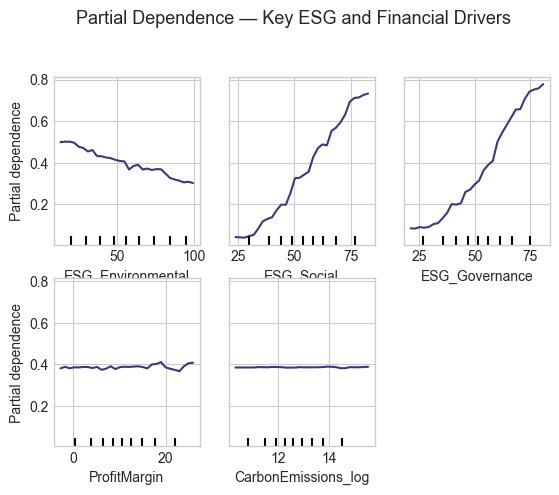

PermutationExplainer explainer: 801it [00:32, 16.99it/s]                         


🔍 SHAP interaction between ESG_Governance and ProfitMargin


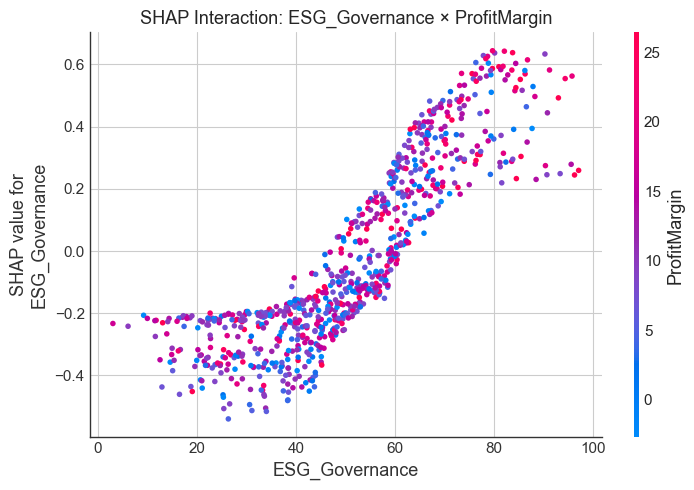

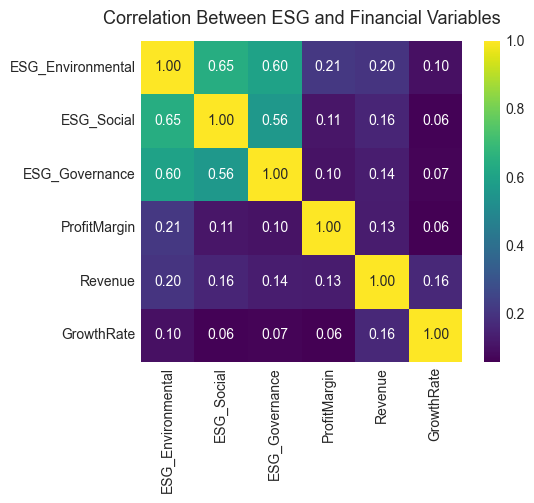

In [5]:
# %% ===============================================================
# STEP 3B — SHAP INTERACTION & PARTIAL DEPENDENCE SUMMARY
# ===============================================================
from sklearn.inspection import PartialDependenceDisplay

# --- 3B.1 Partial Dependence for selected ESG & financial features ---
features_to_plot = [
    "ESG_Environmental",
    "ESG_Social",
    "ESG_Governance",
    "ProfitMargin",
    "CarbonEmissions_log"
]

print("📊 Generating Partial Dependence plots...")
PartialDependenceDisplay.from_estimator(
    xgb, 
    X, 
    features_to_plot, 
    kind="average", 
    grid_resolution=30, 
    n_jobs=-1
)
plt.suptitle("Partial Dependence — Key ESG and Financial Drivers", y=1.02, fontsize=13)
plt.show()


# --- 3B.2 SHAP Interaction Visualization ---
# Use a smaller sample for clarity
sample_X = X.sample(800, random_state=42)
explainer = shap.Explainer(xgb.predict, sample_X)
shap_values = explainer(sample_X)

# Choose one representative ESG and one financial variable
feature_1 = "ESG_Governance"
feature_2 = "ProfitMargin"

print(f"🔍 SHAP interaction between {feature_1} and {feature_2}")
shap.dependence_plot(
    feature_1,
    shap_values.values,
    sample_X,
    interaction_index=feature_2,
    show=False
)
plt.title(f"SHAP Interaction: {feature_1} × {feature_2}", fontsize=13)
plt.tight_layout()
plt.show()


# --- 3B.3 Pairwise ESG–Financial correlation map (for context) ---
plt.figure(figsize=(6,5))
subset_cols = ["ESG_Environmental","ESG_Social","ESG_Governance","ProfitMargin","Revenue","GrowthRate"]
corr = X[subset_cols].corr()
sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f", square=True)
plt.title("Correlation Between ESG and Financial Variables", fontsize=13, pad=12)
plt.tight_layout()
plt.show()

In [6]:
# %% ===============================================================
# STEP 4 — ESG–FINANCIAL TRADE-OFF & SCENARIO ANALYSIS (HELPERS)
# ===============================================================

def _clip_if_in_range(col, s):
    """Clip to sensible ranges when we know them."""
    if col in ["ESG_Environmental", "ESG_Social", "ESG_Governance"]:
        return s.clip(0, 100)
    # ProfitMargin can be negative; keep wide but safe band
    if col in ["ProfitMargin", "GrowthRate"]:
        return s.clip(-100, 100)
    return s  # default: no clip

def scenario_predict(xgb_model, X_base, df_full, scenario_spec):
    """
    Run a 'what-if' scenario and return:
      - baseline probabilities
      - scenario probabilities
      - uplift (scenario - baseline)
      - a modified copy of X used for prediction

    scenario_spec: dict with keys describing changes, e.g.:
      {
        "ESG_Governance": {"add": +10},              # absolute change
        "ESG_Social": {"add": +10},
        "ESG_Environmental": {"add": +10},
        "ProfitMargin": {"add": +3},
        "CarbonEmissions_log": {"rel_emissions": -0.20},  # relative change to raw emissions, then log1p
      }
    """
    # Baseline
    base_prob = xgb_model.predict_proba(X_base)[:, 1]
    X_scn = X_base.copy()

    # Apply changes
    for feature, instr in scenario_spec.items():
        if feature == "CarbonEmissions_log" and "rel_emissions" in instr:
            # Recompute log1p after applying relative change to raw emissions
            rel = instr["rel_emissions"]
            if "CarbonEmissions" not in df_full.columns:
                raise ValueError("Raw 'CarbonEmissions' not available in df for recomputing log feature.")
            new_emissions = (df_full["CarbonEmissions"] * (1 + rel)).clip(lower=0)
            X_scn["CarbonEmissions_log"] = np.log1p(new_emissions)
        else:
            # Absolute add/subtract
            if "add" in instr:
                X_scn[feature] = _clip_if_in_range(feature, X_scn[feature] + instr["add"])

    scn_prob = xgb_model.predict_proba(X_scn)[:, 1]
    uplift = scn_prob - base_prob
    return base_prob, scn_prob, uplift, X_scn

def summarize_uplift(uplift, label):
    """Return a tidy dict of uplift summary stats for reporting."""
    return {
        "Scenario": label,
        "Mean Δprob": float(uplift.mean()),
        "Median Δprob": float(np.median(uplift)),
        "P90 Δprob": float(np.quantile(uplift, 0.90)),
        "Max Δprob": float(uplift.max())
    }

,Scenario,Mean Δprob,Median Δprob,P90 Δprob,Max Δprob
1,Soc +10,0.119,0.085,0.294,0.591
0,Gov +10,0.118,0.078,0.299,0.614
5,Gov +10 & Emissions -20%,0.117,0.078,0.299,0.614
3,PM +3pp,0.001,0.000,0.023,0.220
4,Emissions -20%,-0.000,0.000,0.001,0.074
2,Env +10,-0.022,-0.006,0.004,0.361


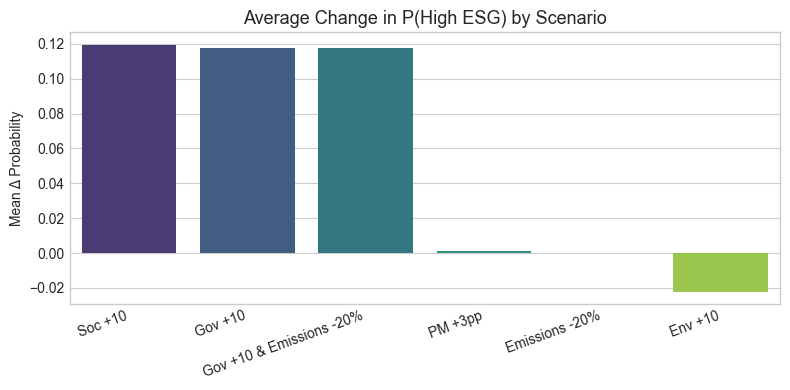

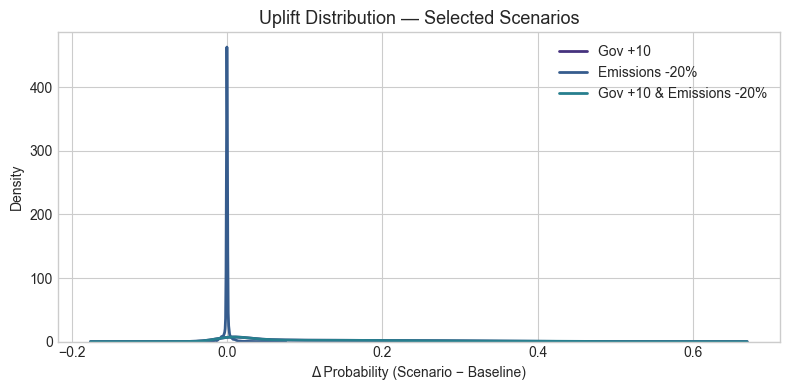

In [7]:
# %% ===============================================================
# STEP 4B — RUN SCENARIOS & VISUALIZE IMPACT
# ===============================================================

# Ensure we use the same model and feature matrix from STEP 3:
# xgb : trained model
# X   : feature matrix (without identifiers and overall scores)
# df  : full dataframe (has raw CarbonEmissions)

scenarios = {
    "Gov +10": {
        "ESG_Governance": {"add": +10},
    },
    "Soc +10": {
        "ESG_Social": {"add": +10},
    },
    "Env +10": {
        "ESG_Environmental": {"add": +10},
    },
    "PM +3pp": {
        "ProfitMargin": {"add": +3},
    },
    "Emissions -20%": {
        "CarbonEmissions_log": {"rel_emissions": -0.20}
    },
    "Gov +10 & Emissions -20%": {
        "ESG_Governance": {"add": +10},
        "CarbonEmissions_log": {"rel_emissions": -0.20}
    },
}

results = []
uplift_store = {}  # keep for plots

for label, spec in scenarios.items():
    base_p, scn_p, uplift, X_scn = scenario_predict(xgb, X, df, spec)
    results.append(summarize_uplift(uplift, label))
    uplift_store[label] = uplift

summary = pd.DataFrame(results).sort_values("Mean Δprob", ascending=False)
display(summary.style.format({"Mean Δprob": "{:.3f}", "Median Δprob": "{:.3f}", "P90 Δprob": "{:.3f}", "Max Δprob": "{:.3f}"}))

# --- Plot mean uplift per scenario ---
plt.figure(figsize=(8,4))
sns.barplot(data=summary, x="Scenario", y="Mean Δprob", palette="viridis")
plt.title("Average Change in P(High ESG) by Scenario", fontsize=13)
plt.ylabel("Mean Δ Probability")
plt.xlabel("")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# --- Optional: distribution plot for a couple of scenarios ---
to_plot = ["Gov +10", "Emissions -20%", "Gov +10 & Emissions -20%"]
plt.figure(figsize=(8,4))
for lab in to_plot:
    sns.kdeplot(uplift_store[lab], label=lab, lw=2)
plt.title("Uplift Distribution — Selected Scenarios", fontsize=13)
plt.xlabel("Δ Probability (Scenario − Baseline)")
plt.legend()
plt.tight_layout()
plt.show()

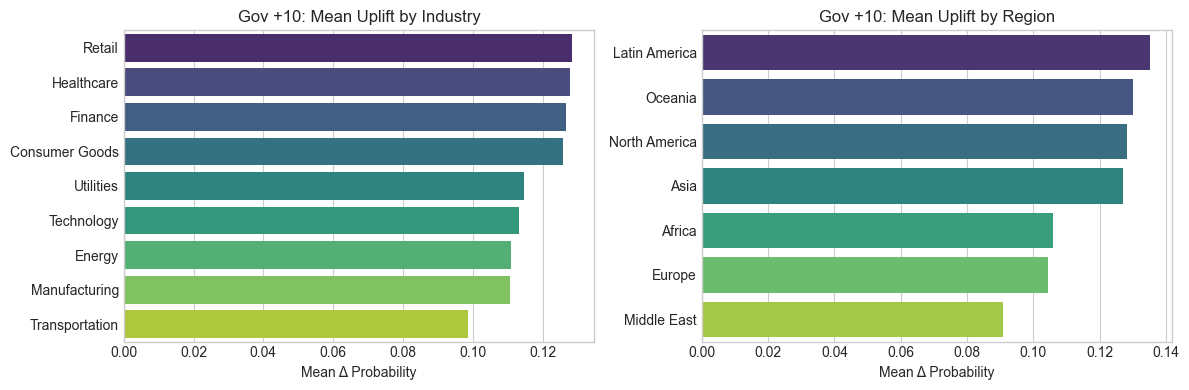

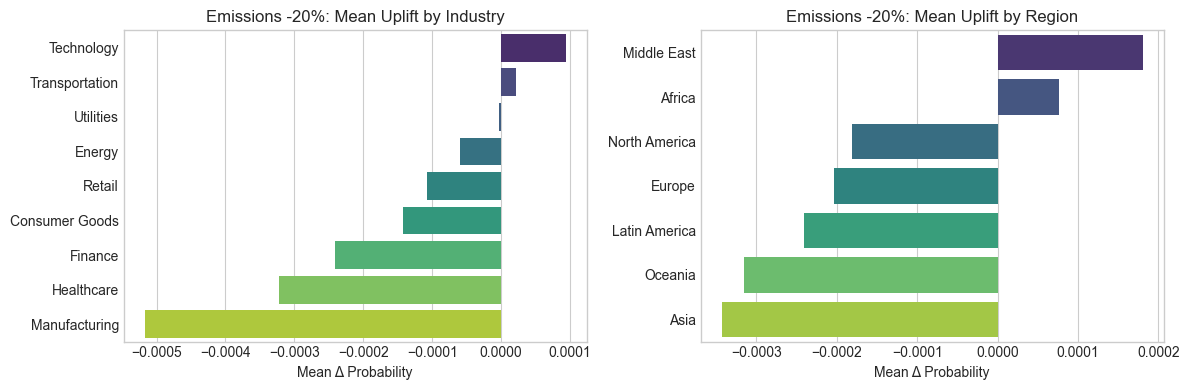

,Gov +10 — Industry,Emissions -20% — Industry
Industry,,
Consumer Goods,0.126,-0.000
Energy,0.111,-0.000
Finance,0.127,-0.000
Healthcare,0.128,-0.000
Manufacturing,0.111,-0.001
Retail,0.128,-0.000
Technology,0.113,0.000
Transportation,0.099,0.000
Utilities,0.115,-0.000


,Gov +10 — Region,Emissions -20% — Region
Region,,
Africa,0.106,0.0
Asia,0.127,-0.0
Europe,0.104,-0.0
Latin America,0.135,-0.0
Middle East,0.091,0.0
North America,0.128,-0.0
Oceania,0.130,-0.0


In [8]:
# %% ===============================================================
# STEP 4C — SECTOR / REGIONAL BREAKDOWN OF SCENARIO IMPACTS
# ===============================================================

# We’ll analyze two key scenarios: Governance +10 and Emissions −20%.
scenarios_to_analyze = {
    "Gov +10": {"ESG_Governance": {"add": +10}},
    "Emissions -20%": {"CarbonEmissions_log": {"rel_emissions": -0.20}}
}

sector_results = []

for label, spec in scenarios_to_analyze.items():
    base_p, scn_p, uplift, X_scn = scenario_predict(xgb, X, df, spec)

    df_analysis = pd.DataFrame({
        "Industry": df["Industry"],
        "Region": df["Region"],
        "Uplift": uplift
    })

    # --- Group by Industry ---
    industry_mean = df_analysis.groupby("Industry")["Uplift"].mean().sort_values(ascending=False)
    region_mean = df_analysis.groupby("Region")["Uplift"].mean().sort_values(ascending=False)

    # --- Store results for later comparison ---
    sector_results.append({
        "Scenario": label,
        "Industry Uplift (mean)": industry_mean,
        "Region Uplift (mean)": region_mean
    })

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.barplot(
        x=industry_mean.values, y=industry_mean.index, palette="viridis", ax=axes[0]
    )
    axes[0].set_title(f"{label}: Mean Uplift by Industry", fontsize=12)
    axes[0].set_xlabel("Mean Δ Probability")
    axes[0].set_ylabel("")

    sns.barplot(
        x=region_mean.values, y=region_mean.index, palette="viridis", ax=axes[1]
    )
    axes[1].set_title(f"{label}: Mean Uplift by Region", fontsize=12)
    axes[1].set_xlabel("Mean Δ Probability")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

# Optional — tidy summary table
summary_sector = pd.DataFrame({
    (f"{res['Scenario']} — Industry"): res["Industry Uplift (mean)"] for res in sector_results
}).round(3)

summary_region = pd.DataFrame({
    (f"{res['Scenario']} — Region"): res["Region Uplift (mean)"] for res in sector_results
}).round(3)

display(summary_sector)
display(summary_region)

In [9]:
# %% ===============================================================
# STEP 5 — EXPORT SCENARIO ANALYSIS RESULTS
# ===============================================================
import json

EXPORT_DIR = OUTPUTS / "scenario_analysis"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# --- 5.1 Export summary of mean uplifts across all scenarios ---
scenario_summary_path = EXPORT_DIR / "scenario_summary.csv"
summary.to_csv(scenario_summary_path, index=False)
print(f"✅ Saved overall scenario summary → {scenario_summary_path.name}")

# --- 5.2 Export uplift distributions for key scenarios ---
uplift_df = pd.DataFrame({label: vals for label, vals in uplift_store.items()})
uplift_df.to_csv(EXPORT_DIR / "uplift_distributions.csv", index=False)
print("✅ Saved uplift distributions for each scenario")

# --- 5.3 Export industry / region breakdowns ---
summary_sector_path = EXPORT_DIR / "sector_uplift_summary.csv"
summary_region_path = EXPORT_DIR / "region_uplift_summary.csv"

summary_sector.to_csv(summary_sector_path)
summary_region.to_csv(summary_region_path)
print(f"✅ Saved industry breakdown → {summary_sector_path.name}")
print(f"✅ Saved regional breakdown → {summary_region_path.name}")

# --- 5.4 Export all key scenario metrics as JSON (for future automation) ---
scenario_json = {
    "summary": summary.to_dict(orient="records"),
    "industry": {k: v.to_dict() for k, v in summary_sector.items()},
    "region": {k: v.to_dict() for k, v in summary_region.items()},
}

with open(EXPORT_DIR / "scenario_metrics.json", "w") as f:
    json.dump(scenario_json, f, indent=2)

print("✅ Exported combined scenario metrics → scenario_metrics.json")

# --- 5.5 Optional: Export a quick visualization snapshot ---
plt.figure(figsize=(8,4))
sns.barplot(data=summary, x="Scenario", y="Mean Δprob", palette="viridis")
plt.title("Average Change in P(High ESG) by Scenario", fontsize=13)
plt.ylabel("Mean Δ Probability")
plt.xlabel("")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scenario_summary_plot.png", dpi=300, bbox_inches="tight")
plt.close()
print("📊 Exported summary plot → scenario_summary_plot.png")

print("\n💾 All scenario analysis results saved successfully!")

✅ Saved overall scenario summary → scenario_summary.csv
✅ Saved uplift distributions for each scenario
✅ Saved industry breakdown → sector_uplift_summary.csv
✅ Saved regional breakdown → region_uplift_summary.csv
✅ Exported combined scenario metrics → scenario_metrics.json
📊 Exported summary plot → scenario_summary_plot.png

💾 All scenario analysis results saved successfully!
